Implementation of the RNN with FastText embedding.



In [1]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.nn import relu, softmax
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix 
from tensorflow.contrib.layers import batch_norm, dropout
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import math_ops

#import training, validation and test set, with FastText embedding
with open('train_sentences_fasttext_balanced.pickle','rb') as file:
    training_sentences = pickle.load(file)
    
with open('train_labels_balanced.pickle','rb') as file:
    training_labels = pickle.load(file)
    
    
with open('valid_sentences_fasttext_balanced.pickle','rb') as file:
    validation_sentences = pickle.load(file)
    
with open('valid_labels_balanced.pickle','rb') as file:
    validation_labels = pickle.load(file)
    

with open('test_sentences_fasttext_balanced.pickle','rb') as file:
    test_sentences = pickle.load(file)
    
with open('test_labels_balanced.pickle','rb') as file:
    test_labels = pickle.load(file)
    
with open('test_word_sentences_balanced.pickle','rb') as file:
    test_word_sentences = pickle.load(file)

#print(test_sentences[0][:])
print(test_word_sentences[0])
print(test_labels[0])
 

/Users/claire/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


['Finanseksperter vurderer at de kan tjene 100% af den investering, de laver, på få år.']
1.0


In [2]:
def init_list_of_objects(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( list() ) #different object reference each time
    return list_of_objects

In [3]:
#information about the dataset

num_training=len(training_sentences)
num_valid=len(validation_sentences)
num_test=len(test_sentences)

num_claims_train=sum(training_labels)
num_claims_valid=sum(validation_labels)
num_claims_test=sum(test_labels)

print('total number of sentences:',num_training+num_valid+num_test)
print('number of training exemples:',num_training)
print('number of validation exemples:',num_valid)
print('number of test exemples:',num_test)
print('Total number of claims: ', num_claims_train+num_claims_valid+num_claims_test)
print('Number of claims in the training set: ', num_claims_train)
print('Number of claims in the validation set: ', num_claims_valid)
print('Number of claims in the test set: ', num_claims_test)


max_input_len_train = max([len(list(i)) for i in training_sentences])
max_input_len_valid = max([len(list(i)) for i in validation_sentences])
max_input_len_test = max([len(list(i)) for i in test_sentences])
max_input_len=max(max_input_len_train,max_input_len_valid,max_input_len_test)
print('maximum input length:',max_input_len)

total number of sentences: 13578
number of training exemples: 8149
number of validation exemples: 2629
number of test exemples: 2800
Total number of claims:  5680.0
Number of claims in the training set:  3410.0
Number of claims in the validation set:  1040.0
Number of claims in the test set:  1230.0
maximum input length: 41


In [4]:
#processing inputs
#zero padding on inputs

seq_len_train = []
train_exemples = np.zeros((num_training, max_input_len, 300))
for (i,sent) in enumerate(training_sentences):
        cur_len = len(list(sent))
        for (j,vect) in enumerate(sent):
            train_exemples[i,j,:] = vect
        seq_len_train.append(cur_len)
seq_len_train=np.asarray(seq_len_train)


seq_len_valid = []
valid_exemples = np.zeros((num_valid, max_input_len, 300))
for (i,sent) in enumerate(validation_sentences):
        cur_len = len(list(sent))
        for (j,vect) in enumerate(sent):
            valid_exemples[i,j,:] = vect
        seq_len_valid.append(cur_len)
seq_len_valid=np.asarray(seq_len_valid)

seq_len_test = []
test_exemples = np.zeros((num_test, max_input_len, 300))
for (i,sent) in enumerate(test_sentences):
        cur_len = len(list(sent))
        for (j,vect) in enumerate(sent):
            test_exemples[i,j,:] = vect
        seq_len_test.append(cur_len)
seq_len_test=np.asarray(seq_len_test)



In [5]:
dim_output_network=2
num_embeddings=train_exemples.shape[2]

print('training exemples shape: ', train_exemples.shape)
print('network output dimension:',dim_output_network)
print('word embedding dimension:',num_embeddings)


training exemples shape:  (8149, 41, 300)
network output dimension: 2
word embedding dimension: 300


In [6]:
def get_batch(batch_size=32, random=False, k=0):
    
    if random==True:
        indexes=np.random.choice(np.arange(num_training), (batch_size,), False)
        batch_exemples = train_exemples[indexes,:]
        batch_labels = training_labels[indexes]
        length = seq_len_train[indexes]
        return batch_exemples, batch_labels, length

    
    else:
        if (k+batch_size<num_training or k+batch_size==num_training):
            batch_exemples = train_exemples[k:batch_size+k,:]
            batch_labels = training_labels[k:batch_size+k]
            length = seq_len_train[k:batch_size+k]
            #mask=targets_mask[k:batch_size+k,:]
            index=k+batch_size
        else:
            batch_exemples = np.concatenate((train_exemples[k:num_training,:],\
                                             train_exemples[0:batch_size-(num_training-k),:]),axis=0) 
            batch_labels = np.concatenate((training_labels[k:num_training],\
                                           training_labels[0:batch_size-(num_training-k)]),axis=0) 
            length = np.concatenate((seq_len_train[k:num_training],seq_len_train[0:batch_size-(num_training-k)]),axis=0)
            
            index=batch_size-(num_training-k)
        
        return batch_exemples, batch_labels, length, index

In [7]:
# resetting the graph
tf.reset_default_graph()

# Setting up hyperparameters and general configs

NUM_OUTPUTS = dim_output_network 
NUM_EMBEDDINGS=num_embeddings
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_UNITS_ENC = 8


# Setting up placeholders

# Data input
x_pl = tf.placeholder(tf.float32, shape=[None, None, NUM_EMBEDDINGS], name='X_input')
# Binary labels
y_pl = tf.placeholder(tf.int32, shape=[None, ], name='output')
# Length of the input sequence i.e. number of words
x_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
#positive class threshold
threshold_pl=tf.placeholder(tf.float32, shape=[], name='threshold')

print('x_pl shape:',x_pl.shape)
print('y_pl shape:',y_pl.shape)
print('x_len shape:',x_len.shape)
print('threshold_pl shape:',threshold_pl.shape)


### Building the model

enc_cell = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC, kernel_initializer=tf.orthogonal_initializer)
_, enc_state = tf.nn.dynamic_rnn(cell=enc_cell, inputs=x_pl,
                                 sequence_length=x_len, dtype=tf.float32)

# setting up weights for computing the final output
W_out = tf.get_variable('W_out', [NUM_UNITS_ENC, NUM_OUTPUTS])
b_out = tf.get_variable('b_out', [NUM_OUTPUTS])

# computing output
y = tf.nn.softmax(tf.matmul(enc_state, W_out) + b_out, name='l_out')


x_pl shape: (?, ?, 300)
y_pl shape: (?,)
x_len shape: (?,)
threshold_pl shape: ()


In [8]:

def sequence_loss_tensor(logits, targets,
                         average_across_timesteps=True,
                         softmax_loss_function=None, name=None):
    """cross-entropy loss for a sequence of logits (per example).
    """
    
    name = "sequenceLoss" if name is None else name
    with tf.variable_scope(name):
    
        if softmax_loss_function is None:
            crossent = nn_ops.sparse_softmax_cross_entropy_with_logits(
                    logits=logits, labels=targets)
            
        else:
            crossent = softmax_loss_function(logits, targets)
        
        crossent = tf.reduce_mean(crossent)


        return crossent


In [9]:
# 1) Define cross entropy loss
with tf.variable_scope('loss'):
    loss = sequence_loss_tensor(y, y_pl) #compute cross entropy
    #regularization
    reg_scale = 0.0001
    regularize = tf.contrib.layers.l1_regularizer(reg_scale)
    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    reg_term = sum([regularize(param) for param in params])
    loss += reg_term

# 2) Define the training op
with tf.variable_scope('trainOP'):
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)  
    
    # use global step to keep track of our iterations
    global_step = tf.Variable(0, name='global_step', trainable=False)
    grads_and_vars = optimizer.compute_gradients(loss)
    train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

with tf.variable_scope('performance'):
    
        binary_pred=tf.greater(y[:,1], threshold_pl)
        binary_pred=tf.cast(binary_pred,tf.int32, name='predictions')
        # making a one-hot encoded vector of correct (1) and incorrect (0) prediction
        correct_prediction = tf.equal(binary_pred, y_pl)
        # averaging the one-hot encoded vector
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
        _, auc_op = tf.contrib.metrics.streaming_auc(predictions=y[:,1], labels=y_pl, num_thresholds=300)                                           
        _, sensitivity_op= tf.metrics.recall(labels=y_pl, predictions=binary_pred)
        conf_matrix = tf.confusion_matrix(labels=y_pl, predictions=binary_pred, num_classes=2, name='confusion_matrix')
        specificity = tf.divide(conf_matrix[0,0], conf_matrix[0,0] + conf_matrix[0,1], name='specificity') 

In [11]:
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.35)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.global_variables_initializer())

In [12]:
#Test the forward pass
batch_size = 32

# Get a mini-batch
x_batch=train_exemples[0:batch_size,:]
print('x_batch shape:',np.shape(x_batch))
y_batch=training_labels[0:batch_size]
print('y_batch shape:',np.shape(y_batch))
x_length=seq_len_train[0:batch_size]
feed_dict = {x_pl: x_batch, x_len: x_length, y_pl: y_batch}

# test training forwardpass
fetches = [y]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y", res[0].shape)

x_batch shape: (32, 41, 300)
y_batch shape: (32,)
y (32, 2)


In [13]:
#Training Loop

# setting up running parameters
val_interval = 150
batches_to_process = 5e3
batches_processed = 0
threshold=0.35
index=0
batches_valid= []
val_loss, val_acc, val_auc, val_sens, val_spec = [], [], [], [], []
train_loss, train_acc, train_auc, train_sens, train_spec = [], [], [], [], []
val_num=0


print('Begin training loop')
try:
    while batches_processed < batches_to_process:
        # load data
        x_tr, y_tr, x_len_tr, index = get_batch(batch_size=BATCH_SIZE, random=False, k=index)
        # make fetches
        fetches_tr = [train_op, loss, accuracy, auc_op, sensitivity_op, specificity]
         #set up feed dict
        feed_dict_tr = {x_pl: x_tr, x_len: x_len_tr, y_pl: y_tr, threshold_pl : threshold}
        # run the model
        sess.run(tf.local_variables_initializer())
        res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
        _, batch_loss, batch_acc, batch_auc, batch_sens, batch_spec = res
        batches_processed += 1
        
        if batches_processed % val_interval == 0:
            train_loss += [batch_loss]
            train_acc += [batch_acc]
            train_auc += [batch_auc]
            train_sens += [batch_sens]
            train_spec += [batch_spec]
            print("Batch number {}: Train Loss {:6.3f},  Train Acc {:6.3f}, Train AUC {:6.3f}, Train Sensitivity {:6.3f}, Train Specificity {:6.3f}".format(
                batches_processed, train_loss[-1], train_acc[-1], train_auc[-1], train_sens[-1], train_spec[-1] ))
            
            #validation 
            val_num=val_num+1
            fetches_valid = [loss, accuracy, auc_op, sensitivity_op, specificity]
            feed_dict_valid = {x_pl: valid_exemples, x_len: seq_len_valid, y_pl: validation_labels, threshold_pl : threshold}
            sess.run(tf.local_variables_initializer())
            _loss, _acc, _auc, _sens, _spec = sess.run(fetches_valid, feed_dict_valid)
            val_acc += [_acc]
            val_loss += [_loss]
            val_auc+= [_auc]
            val_sens+= [_sens]
            val_spec+= [_spec]
            batches_valid += [batches_processed]
            print("Validation number {}: Val Loss {:6.3f},  Val Acc {:6.3f}, Val AUC {:6.3f}, Val Sensitivity {:6.3f}, Val Specificity {:6.3f}".format(
                    val_num, val_loss[-1], val_acc[-1], val_auc[-1], val_sens[-1], val_spec[-1]))
            
    #test
    feed_dict_test = {x_pl: test_exemples, x_len: seq_len_test, y_pl: test_labels, threshold_pl : threshold}
    fetches_test = [loss, accuracy, auc_op, sensitivity_op, specificity, binary_pred, y]
    sess.run(tf.local_variables_initializer())
    test_loss, test_acc, test_auc, test_sens, test_spec, test_pred, test_prob = sess.run(fetches_test, feed_dict_test)
    
    fpr_test, tpr_test, _ = roc_curve(test_labels, test_prob[:,1])
    roc_auc_test = auc(fpr_test, tpr_test)
    TN, FP, FN, TP = confusion_matrix(test_labels, test_pred).ravel()

    test_accuracy=(TN+TP)/float(TN+FP+FN+TP) #prop di risposte corrette in tot
    test_sensitivity = TP / float(FN + TP) #veri p
    test_specificity = TN / (TN + FP) #
    print('Test Loss {:6.3f}, Test Acc {:6.3f}, Test AUC {:6.3f}, Test Sensitivity {:6.3f}, Test Specificity {:6.3f}'.format(
                    test_loss, test_acc, test_auc, test_sens, test_spec))
    print('Test Loss {:6.3f}, Test Acc {:6.3f}, Test AUC {:6.3f}, Test Sensitivity {:6.3f}, Test Specificity {:6.3f}'.format(
                    test_loss, test_accuracy, roc_auc_test, test_sensitivity, test_specificity))
except KeyboardInterrupt:
    pass

print('Done')
           

Begin training loop
Batch number 150: Train Loss  0.721,  Train Acc  0.562, Train AUC  0.514, Train Sensitivity  1.000, Train Specificity  0.222
Validation number 1: Val Loss  0.704,  Val Acc  0.452, Val AUC  0.606, Val Sensitivity  0.894, Val Specificity  0.162
Batch number 300: Train Loss  0.679,  Train Acc  0.656, Train AUC  0.767, Train Sensitivity  0.846, Train Specificity  0.526
Validation number 2: Val Loss  0.686,  Val Acc  0.571, Val AUC  0.655, Val Sensitivity  0.740, Val Specificity  0.460
Batch number 450: Train Loss  0.693,  Train Acc  0.562, Train AUC  0.614, Train Sensitivity  0.533, Train Specificity  0.588
Validation number 3: Val Loss  0.673,  Val Acc  0.620, Val AUC  0.680, Val Sensitivity  0.673, Val Specificity  0.585
Batch number 600: Train Loss  0.667,  Train Acc  0.500, Train AUC  0.608, Train Sensitivity  0.727, Train Specificity  0.381
Validation number 4: Val Loss  0.662,  Val Acc  0.635, Val AUC  0.696, Val Sensitivity  0.663, Val Specificity  0.616
Batch nu

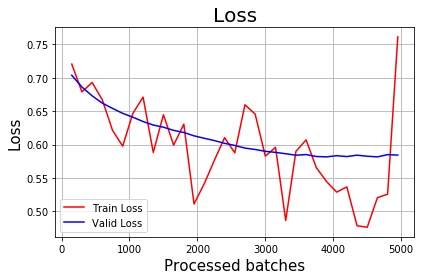

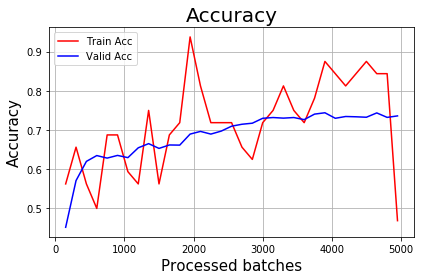

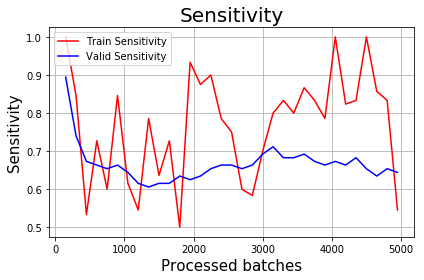

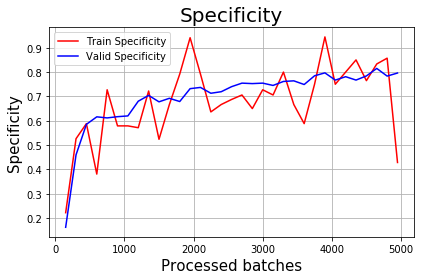

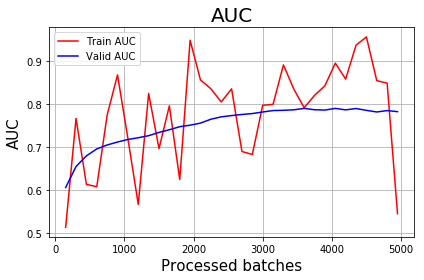

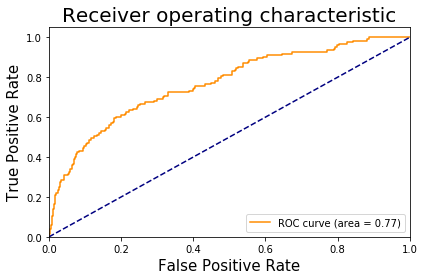

In [15]:
#plot learning curves

fig=plt.figure()
fig.add_subplot()
plt.plot(batches_valid, train_loss, 'r-', label='Train Loss')
plt.plot(batches_valid, val_loss, 'b-', label='Valid Loss')
plt.legend()
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Processed batches', fontsize=15)
plt.title('Loss', fontsize=20)
plt.grid('on')
plt.tight_layout()
plt.show()    
            
fig.add_subplot()
plt.plot(batches_valid, train_acc, 'r-', label='Train Acc')
plt.plot(batches_valid, val_acc, 'b-', label='Valid Acc')
plt.legend()
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Processed batches', fontsize=15)
plt.title('Accuracy', fontsize=20)
plt.grid('on')
plt.tight_layout()
plt.show()       


fig=plt.figure()
fig.add_subplot()
plt.plot(batches_valid, train_sens, 'r-', label='Train Sensitivity')
plt.plot(batches_valid, val_sens, 'b-', label='Valid Sensitivity')
plt.legend()
plt.ylabel('Sensitivity', fontsize=15)
plt.xlabel('Processed batches', fontsize=15)
plt.title('Sensitivity', fontsize=20)
plt.grid('on')
plt.tight_layout()
plt.show()   

fig.add_subplot()
plt.plot(batches_valid, train_spec, 'r-', label='Train Specificity')
plt.plot(batches_valid, val_spec, 'b-', label='Valid Specificity')
plt.legend()
plt.ylabel('Specificity', fontsize=15)
plt.xlabel('Processed batches', fontsize=15)
plt.title('Specificity', fontsize=20)
plt.grid('on') 
plt.tight_layout()
plt.show()   

plt.figure()
plt.plot(batches_valid, train_auc, 'r-', label='Train AUC')
plt.plot(batches_valid, val_auc, 'b-', label='Valid AUC')
plt.legend()
plt.legend()
plt.ylabel('AUC', fontsize=15)
plt.xlabel('Processed batches', fontsize=15)
plt.title('AUC', fontsize=20)
plt.grid('on')
plt.tight_layout()
plt.show()  

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()





In [19]:
## Save model

saver = tf.train.Saver()
saver.save(sess, "./rnn_fasttext_8units")


'./rnn_fasttext_8units'

In [18]:
#see some exemples

unique_test_sentences = [] 
unique_test_labels = []
unique_test_pred = []


for (i,sent) in enumerate(test_word_sentences):
    if sent not in unique_test_sentences:
        #print(sent)
        unique_test_sentences.append(sent)
        unique_test_labels.append(test_labels[i])
        unique_test_pred.append(test_pred[i])
        
true_pos = []
false_pos = []
true_neg = []
false_neg = []

print('Number of test sentences: ',len(test_word_sentences))
print('Number of unique test sentences: ',len(unique_test_sentences))

for (i,pred) in enumerate(unique_test_pred):
    if(pred==1):
        if (unique_test_labels[i]==1):
            true_pos.append(unique_test_sentences[i])
        else:
             false_pos.append(unique_test_sentences[i])
    else:
        if (unique_test_labels[i]==1):
            false_neg.append(unique_test_sentences[i])
        else:
             true_neg.append(unique_test_sentences[i])
    
print('\nTrue positives: ')
for i in np.arange(min(10,len(true_pos))):
    print(true_pos[i])
print('\nFalse positives: ')
for i in np.arange(min(10,len(false_pos))):
    print(false_pos[i])
print('\nTrue negatives: ')
for i in np.arange(min(10,len(true_neg))):
    print(true_neg[i])
print('\nFalse negatives: ')
for i in np.arange(min(10,len(false_neg))):
    print(false_neg[i])   

Number of test sentences:  2800
Number of unique test sentences:  1689

True positives: 
['Finanseksperter vurderer at de kan tjene 100% af den investering, de laver, på få år.']
['I dag tildeler man førtidspension til langt færre, end man gjorde før.']
['Alternative diæter er tidens store sundhedstrend og mange familier følger den nyeste kostreligion.']
['Virksomheder betaler ikke energiafgifter som andre forbrugere.']
['Dumpeprocenterne på de fag er steget fra 10% til 50%.']
['Domstolen siger, at nu kan man gifte sig med en illegal indvandrer og få familiesammenføring. Så bliver det mere attraktivt at søge og at komme herop og få offentlige ydelser.']
['Der er investeret næsten 500 mio. kr. over de første år blandt 3700 indbyggere. Det er rigtig mange penge per indbygger.']
['Når man ser på Sveriges fedmeprocent, rammer det i niveau med Danmark.']
['De vil til næste år beløbe sig til 42 mia. kr.']
['Selv om det måske kun er 500 arbejdspladser skal man gange det tal med fire, fordi un